# Libraries


In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
from PIL import Image 

import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
from torchvision import models, transforms 
import torchvision.models as models 
from torch.utils.data import DataLoader, Dataset 


In [2]:
!pip install torchview
import torchview


In [4]:
# Defining the paths for the training and testing data
base_dir = '../input/'
train_csv = '../input/digit-recognizer/train.csv'
test_csv = '../input/digit-recognizer/test.csv'


# Set the device which we will be using for the model - Kaggle Notebooks
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Read in Data

In [5]:
# Class for reading in training and test data
class manualDataset(Dataset):
    def __init__(self, file_path, split='train', val_split=False):
        df = pd.read_csv(file_path)
        self.split = split
        self.val_split = val_split
        if self.split=='test' and val_split==False :
            # test data
            self.raw_files = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.labels = None
        else:
            # training data
            self.raw_files = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.labels = torch.from_numpy(df.iloc[:,0].values)
        
        if(val_split):
            self.raw_files = self.raw_files[:10]
          
       
        self.train_transform = transforms.Compose([ transforms.ToPILImage(),transforms.RandomHorizontalFlip(), transforms.ToTensor()])
        self.test_transform = transforms.Compose([ transforms.ToTensor()])
          

        
    def __len__(self):
        return len(self.raw_files)
    
    def __getitem__(self, idx):
        # Reading in the image file
        raw = self.raw_files[idx]
      
        if self.split == 'train' or self.val_split:
            raw = self.train_transform(raw)
            label = self.labels[idx]
            return raw, label
        elif self.split == 'test':
            raw = self.test_transform(raw)
            return raw


In [6]:
train_dataset = manualDataset(train_csv, split='train')
test_dataset = manualDataset(test_csv, split='test')
val_dataset = manualDataset(train_csv, split='test', val_split=True)

# Define batch sizes
train_batch_size = 32
test_batch_size = 1

# Create instances of data loader for train, test, validation data
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)


In [7]:
# CNN Model Code Heavily Drawn from OSU's CS 434 ML Class
class CNN(nn.Module):    
    def __init__(self):
        super().__init__()
        
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(inplace=True),  
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  
            nn.Linear(64 * 7 * 7, 512),  
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10)  
        )
        
    def forward(self, x):
        x = self.cnn(x)  
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)  
        
        return x


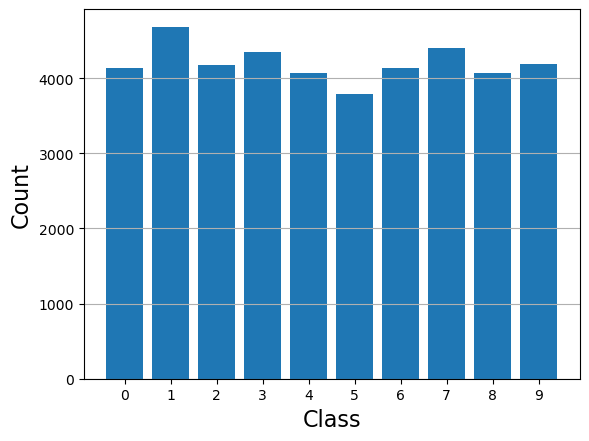

In [9]:
train_df = pd.read_csv(train_csv)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(10))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

In [11]:
model = CNN()
model = model.to(device)
# Defining the loss function and optimizer for training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

epochs = 10

# Setting the model to training mode
model.train()

# Training the model for the specified number of epochs
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    # Iterating through the training data
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data)
  
     
        loss = criterion(output, label)
     
      
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += (loss.item())/len(train_loader)
        
    print('Epoch : {},  train loss : {}'.format(epoch+1,epoch_loss))
    
    # Setting the model to evaluation mode
    model.eval()
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        
        # Iterating through the validation data
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
     
            output = model(data)
           

            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {} , val_loss : {}'.format(epoch+1,epoch_val_loss))


Epoch : 1,  train loss : 0.6279171876558248
Epoch : 1 , val_loss : 0.054231010377407074
Epoch : 2,  train loss : 0.11111730011503661
Epoch : 2 , val_loss : 0.006079550366848707
Epoch : 3,  train loss : 0.06392072013395146
Epoch : 3 , val_loss : 0.007218785583972931
Epoch : 4,  train loss : 0.0462035660926473
Epoch : 4 , val_loss : 0.0006221388466656208
Epoch : 5,  train loss : 0.03849585958651574
Epoch : 5 , val_loss : 0.0002200471644755453
Epoch : 6,  train loss : 0.03010549864825425
Epoch : 6 , val_loss : 0.00025238090893253684
Epoch : 7,  train loss : 0.027293823499626012
Epoch : 7 , val_loss : 5.487477028509602e-05
Epoch : 8,  train loss : 0.023350773761180565
Epoch : 8 , val_loss : 0.00023753898858558387
Epoch : 9,  train loss : 0.01895137846084597
Epoch : 9 , val_loss : 3.751023905351758e-05
Epoch : 10,  train loss : 0.017174421939776044
Epoch : 10 , val_loss : 0.00012762424012180418


# Visualization of Predictions

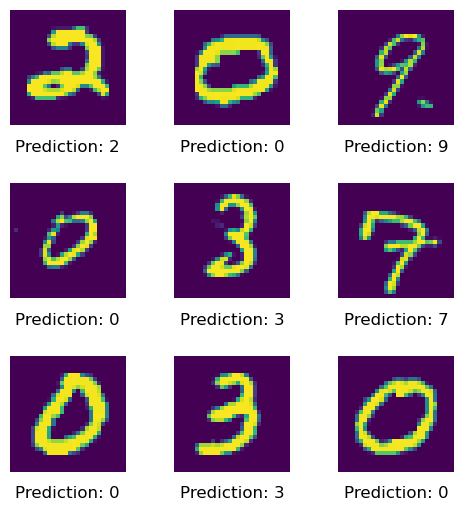

In [12]:
model.eval()
_,ax = plt.subplots(3,3,figsize=(6,6))
for i, data in enumerate(test_loader):
    
 
    data = data.cuda()

    output = model(data)
    

    pred = output.cpu().data.max(1, keepdim=True)[1]
    
    ax[i//3][i%3].imshow(data.cpu().squeeze())
    ax[i//3][i%3].axis('off')
    ax[i//3][i%3].set_title(f"Prediction: {pred.item()}",y=-0.3)
    if(i==8): break
plt.subplots_adjust(hspace=0.5)
plt.show()


# Submission

In [13]:
model.eval()
test_pred = torch.LongTensor()

for i, data in enumerate(test_loader):
    
    if torch.cuda.is_available():
        data = data.cuda()

    output = model(data)

    pred = output.cpu().data.max(1, keepdim=True)[1]
    test_pred = torch.cat((test_pred, pred), dim=0)
    
print(test_pred.shape)
submission_df = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submission_df['Label'] = test_pred.numpy().squeeze()
submission_df.to_csv('submission.csv', index=False)

torch.Size([28000, 1])
